In [1]:

%pprint
import sys
sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

import os
from pandas import DataFrame
import pandas as pd
from notebook_utils import NotebookUtilities
import matplotlib.pyplot as plt
import re
import humanize
from datetime import timedelta

nu = NotebookUtilities(data_folder_path=os.path.abspath('../data'))

In [3]:

# Get all CSVs into one data frame
if nu.pickle_exists('frvrs_logs_df'):
    frvrs_logs_df = nu.load_object('frvrs_logs_df')
    print(frvrs_logs_df.shape)
    # df = frvrs_logs_df.sample(4).dropna(axis='columns', how='all')
    # display(df.T)

(842663, 112)



# Number of Patients Engaged

In [4]:

# Number of patients engaged
if nu.pickle_exists('percentage_engaged_df'):
    percentage_engaged_df = nu.load_object('percentage_engaged_df')
else:
    
    # Initialize an empty list to store the data for each session
    rows_list = []
    
    # Loop through each unique UUID and scene combination
    for (session_uuid, scene_index), scene_df in fu.get_session_groupby(extra_column='scene_index'):
        
        # Get the logger version and scene categories
        logger_version = fu.get_logger_version(scene_df)
        is_scene_aborted = fu.get_is_scene_aborted(scene_df)
        scene_type = fu.get_scene_type(scene_df)
    
        # Get the number of patients in the group
        patients_count = fu.get_patient_count(scene_df)
    
        # Initialize a counter for patients engaged in the current group
        patients_engaged = 0
        
        # Loop through each unique patient_id in the current group
        for patient_id, patient_df in scene_df.groupby('patient_id'):
            
            # Create a mask to filter rows where action_type is 'PATIENT_ENGAGED'
            mask_series = (patient_df.action_type == 'PATIENT_ENGAGED')
            
            # If the filtered dataframe has any rows, increment the number of patients engaged
            if patient_df[mask_series].shape[0]: patients_engaged += 1
    
        # If there are any patients in the group, add a row to the results list with the following information:
        # * logger version
        # * session uuid
        # * scene
        # * number of patients in the group
        # * number of patients engaged in the group
        # * percentage of patients engaged in the group
        if patients_count:
            
            # Create a dictionary to store the data for the current group
            row_dict = {}
            for cn in fu.scene_groupby_columns: row_dict[cn] = eval(cn)
            row_dict['logger_version'] = logger_version
            row_dict['is_scene_aborted'] = is_scene_aborted
            row_dict['scene_type'] = scene_type
            row_dict['patients_count'] = patients_count
            row_dict['patients_engaged'] = patients_engaged
            row_dict['percentage_engaged'] = patients_engaged / patients_count
            
            # Append the dictionary to the list of rows
            rows_list.append(row_dict)
    
    # Create a data frame from the list of dictionaries
    percentage_engaged_df = DataFrame(rows_list)
    nu.store_objects(percentage_engaged_df=percentage_engaged_df)

Pickling to C:\Users\DaveBabbitt\Documents\GitHub\itm-analysis-reporting\saves\pkl\percentage_engaged_df.pkl


In [5]:

# Get average number of patients engaged (this could be including the ones that wave, walk, put hands up)
mask_series = (percentage_engaged_df.scene_type == 'Triage') & (percentage_engaged_df.is_scene_aborted == False)
ave_patients_engaged = percentage_engaged_df[mask_series].patients_engaged.mean()
print(f'The average number of patients engaged per scene is {ave_patients_engaged:0.2}.')

The average number of patients engaged per scene is 5.9.


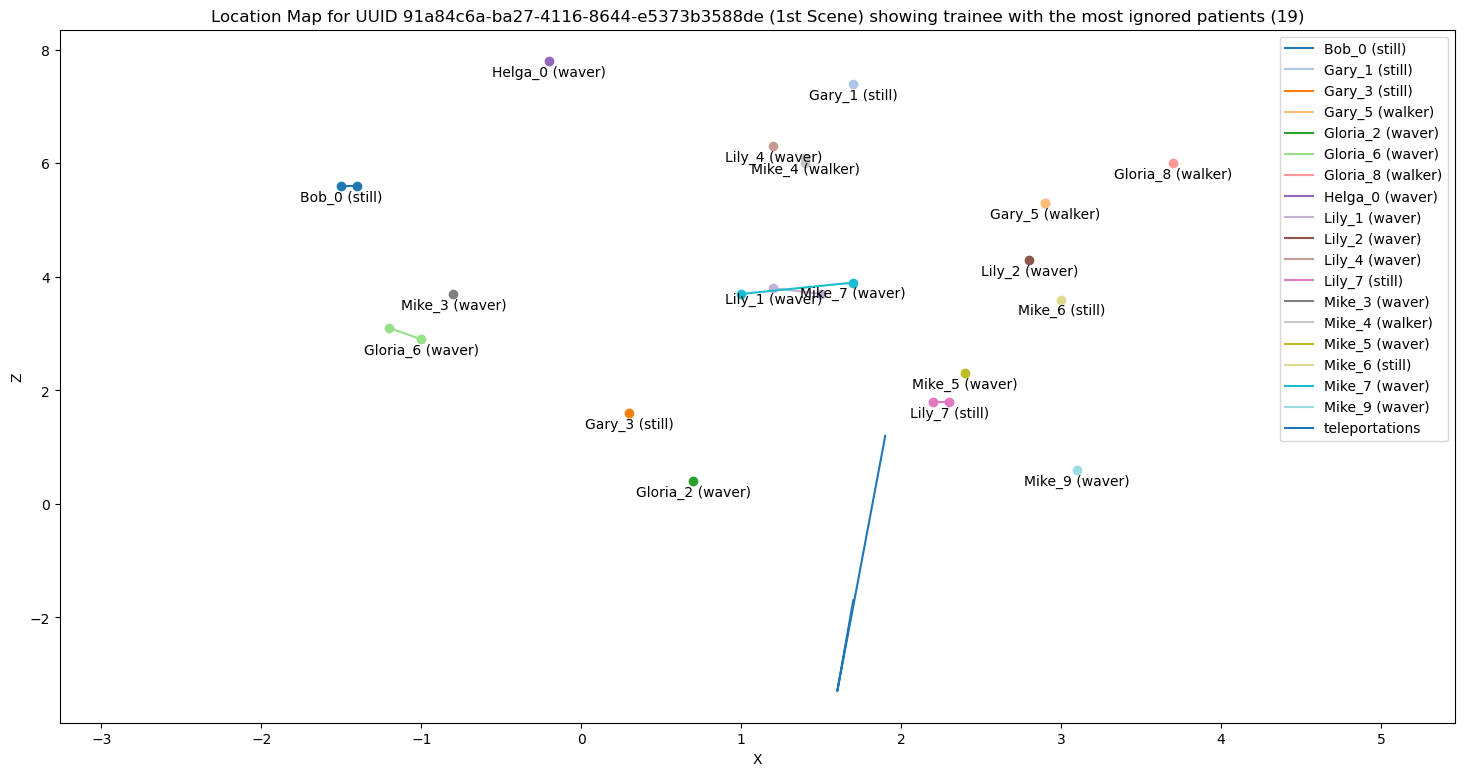

In [6]:

# Get scene with the most ignored patients, v1.3
mask_series = (percentage_engaged_df.percentage_engaged == 0) & (percentage_engaged_df.logger_version == 1.3)
fu.visualize_extreme_player_movement(
    percentage_engaged_df, 'patients_count', mask_series=mask_series, is_ascending=False, humanize_type='intword',
    title_str='most ignored patients', frvrs_logs_df=frvrs_logs_df, verbose=False
)

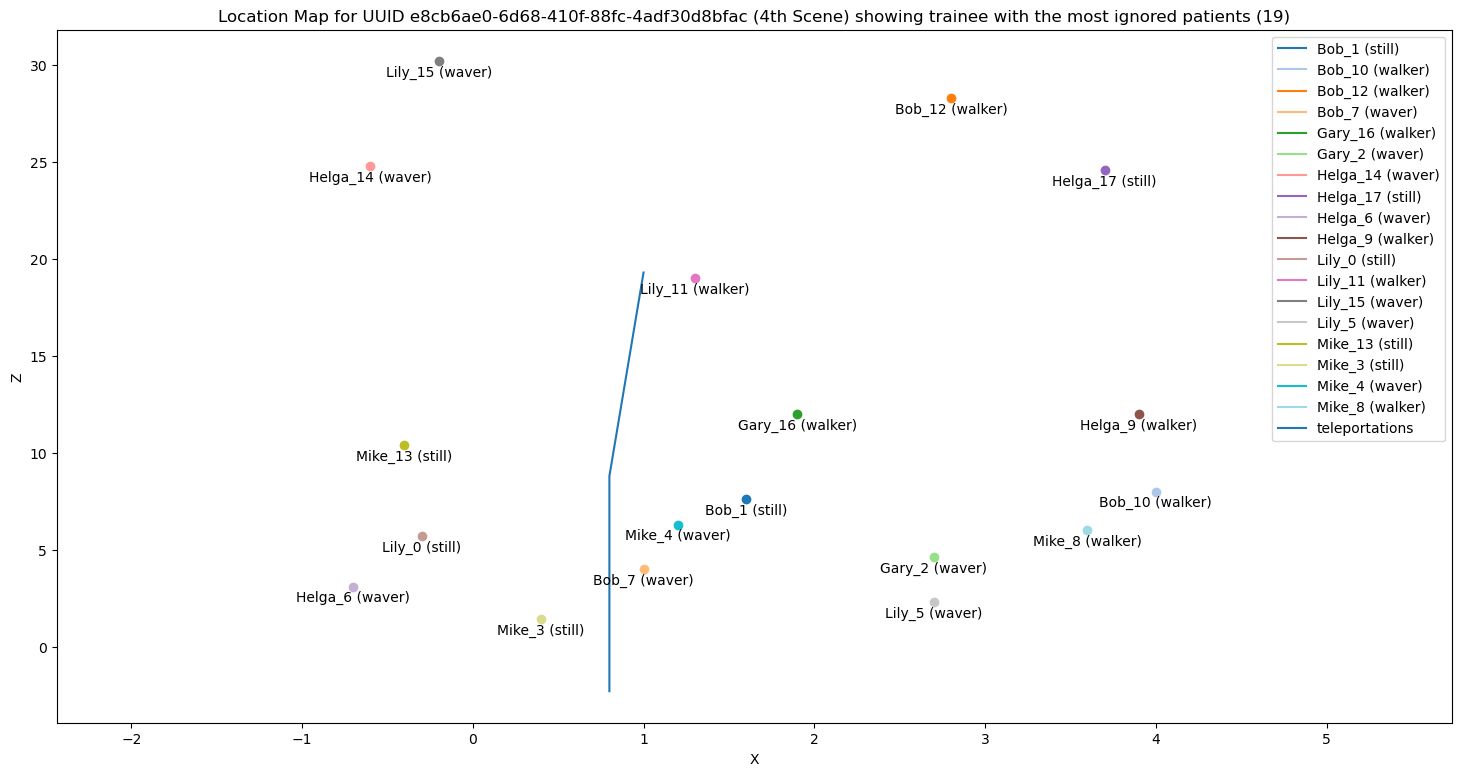

In [7]:

# Get scene with the most ignored patients, v1.0
mask_series = (percentage_engaged_df.percentage_engaged == 0) & (percentage_engaged_df.logger_version == 1.0)
fu.visualize_extreme_player_movement(
    percentage_engaged_df, 'patients_count', mask_series=mask_series, is_ascending=False, humanize_type='intword',
    title_str='most ignored patients', frvrs_logs_df=frvrs_logs_df, verbose=False
)

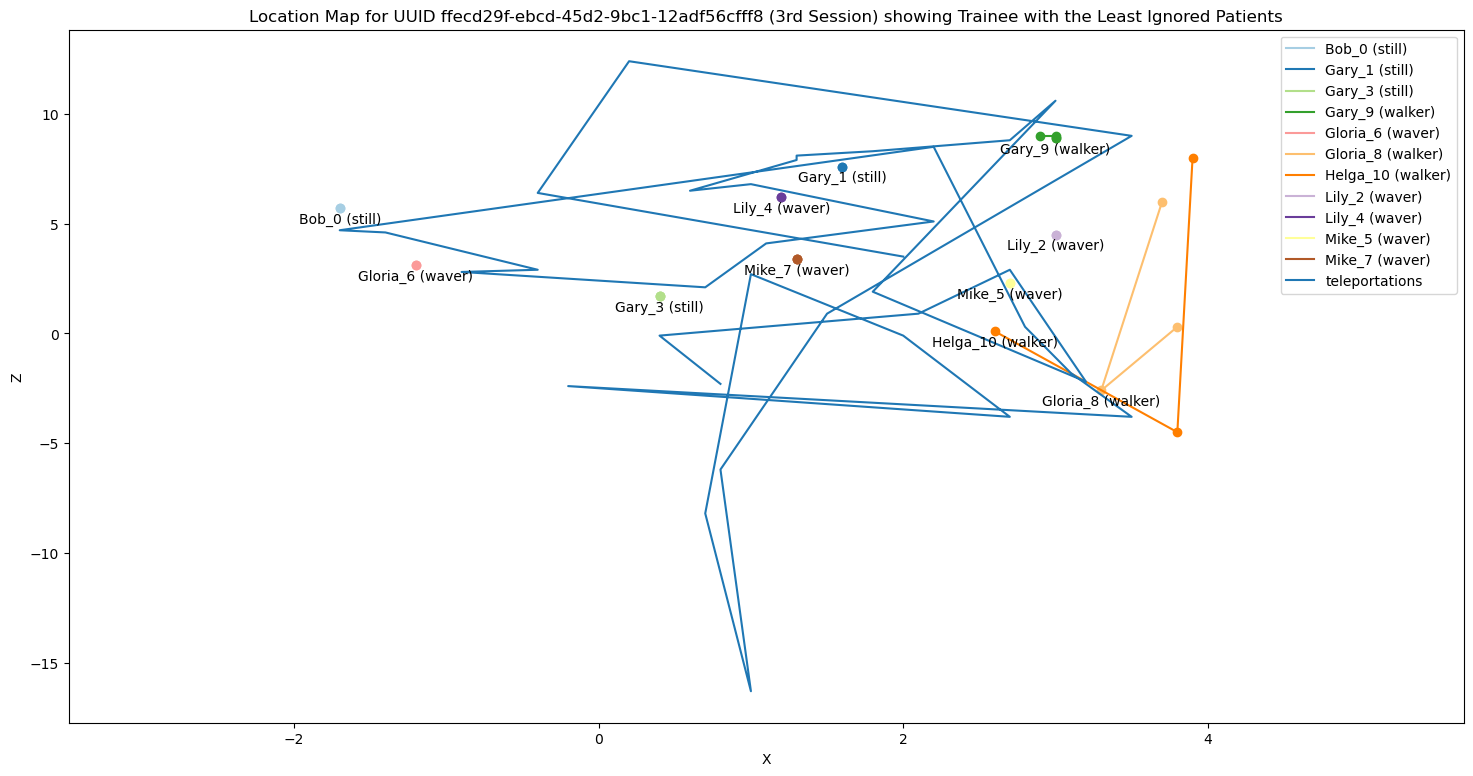

In [8]:

# Get scene with the least ignored patients, v1.3
mask_series = (percentage_engaged_df.logger_version == 1.3)
df = percentage_engaged_df[mask_series].sort_values(['percentage_engaged', 'patients_count']).tail(1)
patients_session_uuid = df.session_uuid.squeeze()
patients_time_group = df.scene_index.squeeze()
base_mask_series = (frvrs_logs_df.session_uuid == patients_session_uuid) & (frvrs_logs_df.scene_index == patients_time_group)

title = f'Location Map for UUID {patients_session_uuid} ({humanize.ordinal(patients_time_group+1)} Session)'
title += ' showing Trainee with the Least Ignored Patients'
fu.visualize_player_movement(base_mask_series, title=title, frvrs_logs_df=frvrs_logs_df)

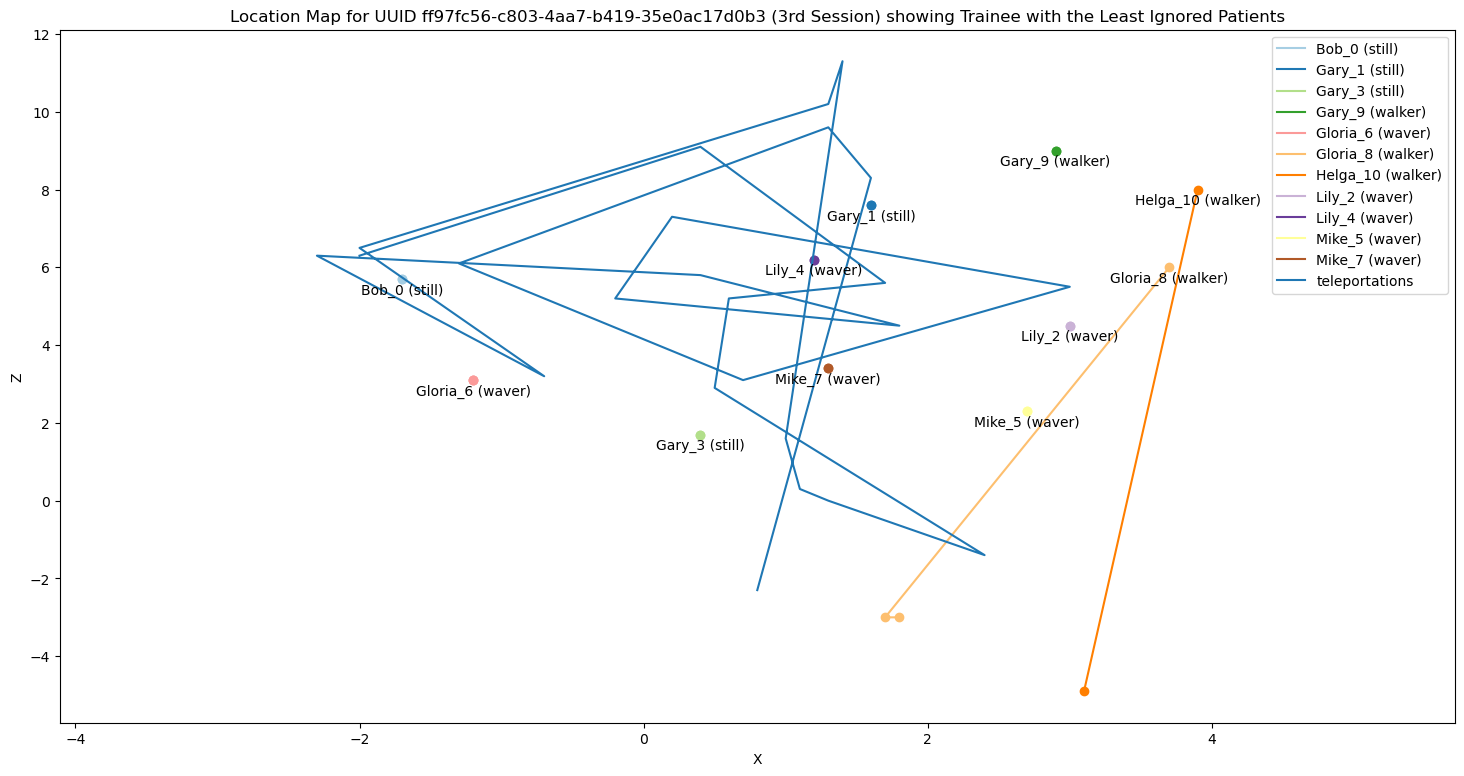

In [9]:

# Get scene with the least ignored patients, v1.0
mask_series = (percentage_engaged_df.logger_version == 1.0)
df = percentage_engaged_df[mask_series].sort_values(['percentage_engaged', 'patients_count']).tail(1)
patients_session_uuid = df.session_uuid.squeeze()
patients_time_group = df.scene_index.squeeze()
base_mask_series = (frvrs_logs_df.session_uuid == patients_session_uuid) & (frvrs_logs_df.scene_index == patients_time_group)

title = f'Location Map for UUID {patients_session_uuid} ({humanize.ordinal(patients_time_group+1)} Session)'
title += ' showing Trainee with the Least Ignored Patients'
fu.visualize_player_movement(base_mask_series, title=title, frvrs_logs_df=frvrs_logs_df)


## How many patients are treated between the walk and wave commands?

In [10]:

mask_series = frvrs_logs_df.voice_command_command_description.map(
    lambda x: ('walk' in str(x).lower()) or ('wave' in str(x).lower())
)
frvrs_logs_df[mask_series].voice_command_command_description.unique().tolist()[:10]

['so you know i would walk in see those four patients i would go and say if anybody can hear me i want you to WLK over here OK', "you use your your global sort commands and then then you'll teleport so go ahead and do that WAVE command OK everybody can hear me wave", 'wave', 'alright everybody can hear me walk this way', 'walk', 'two walkers everybody can hear me wave', "if anybody can walk i want you to walk over here and then once your walkers are out of the way then you're gonna go and say if anyone can wave i want you to wave and then you're gonna know who your patients are that can't follow commands OK if in real life if you come up to somebody that had a complete amputation", 'anybody that can walk walk over here', 'anybody that can wave wave', '15 minutes away OK anybody that can hear me and stand up and walk come over here']

In [11]:

# Display a sample of the data frame, dropping columns with all NaN values and transposing it
mask_series = frvrs_logs_df.voice_command_command_description.isin(['walk', 'wave'])
df = frvrs_logs_df[mask_series]
display(df.sample(min(4, df.shape[0])).dropna(axis='columns', how='all').T)

,52292,106951,716079,77201
action_type,VOICE_COMMAND,VOICE_COMMAND,VOICE_COMMAND,VOICE_COMMAND
action_tick,364660,294969,18659,568574
event_time,2023-03-15 08:27:57,2023-04-25 10:01:03,2023-03-03 11:03:00,2023-04-19 13:06:10
session_uuid,b05e5139-6dd4-41d2-adb5-aedfebb028a6,89ec8f32-0018-48e7-8cad-c86bd73257f2,d4f8b28e-a0a3-4969-a156-5bf86e4794ba,79426650-c950-40ee-816e-decddddd22e9
file_name,All CSV files renamed by date/03.15.23.0843.csv,All CSV files renamed by date/04.25.23.0956.csv,v.1.0/Clean Marty3.csv,All CSV files renamed by date/04.19.23.1310.csv
logger_version,1.3,1.3,1.0,1.3
scene_index,2,2,1,2
voice_command_message,wave if you can,wave if you can,walk to the safe area,wave if you can
voice_command_command_description,wave,wave,walk,wave


In [12]:

actions_list = [
    'wave if you can', 'wave if you can', 'PATIENT_ENGAGED', 'PATIENT_ENGAGED', 'PATIENT_ENGAGED', 'walk to the safe area',
    'PATIENT_ENGAGED', 'walk to the safe area', 'PATIENT_ENGAGED', 'PATIENT_ENGAGED', 'walk to the safe area',
    'PATIENT_ENGAGED', 'PATIENT_ENGAGED', 'PATIENT_ENGAGED', 'PATIENT_ENGAGED', 'PATIENT_ENGAGED', 'PATIENT_ENGAGED',
    'PATIENT_ENGAGED', 'PATIENT_ENGAGED', 'PATIENT_ENGAGED', 'walk to the safe area', 'PATIENT_ENGAGED', 'PATIENT_ENGAGED',
    'PATIENT_ENGAGED', 'PATIENT_ENGAGED', 'PATIENT_ENGAGED', 'PATIENT_ENGAGED', 'PATIENT_ENGAGED', 'PATIENT_ENGAGED',
    'PATIENT_ENGAGED', 'PATIENT_ENGAGED', 'PATIENT_ENGAGED', 'PATIENT_ENGAGED', 'PATIENT_ENGAGED', 'PATIENT_ENGAGED',
    'PATIENT_ENGAGED', 'PATIENT_ENGAGED'
]
result = fu.replace_consecutive_elements(actions_list, element='PATIENT_ENGAGED')
if result != [
    'wave if you can', 'wave if you can', 'PATIENT_ENGAGED x3', 'walk to the safe area', 'PATIENT_ENGAGED x1',
    'walk to the safe area', 'PATIENT_ENGAGED x2', 'walk to the safe area', 'PATIENT_ENGAGED x9', 'walk to the safe area',
    'PATIENT_ENGAGED x16'
]:
    print('Fix first test')
    print(result)
actions_list = ['PATIENT_ENGAGED', 'wave if you can', 'wave if you can', 'walk to the safe area']
result = fu.replace_consecutive_elements(actions_list, element='PATIENT_ENGAGED')
if result != [
    'PATIENT_ENGAGED x1', 'wave if you can', 'wave if you can', 'walk to the safe area'
]:
    print('Fix second test')
    print(result)

In [13]:

# Visualize the number of patients engaged between walk and wave
columns_list = ['voice_command_message', 'action_type']

# Loop through each unique UUID and scene combination
for (session_uuid, scene_index), scene_df in fu.get_session_groupby(extra_column='scene_index'):
    
    # Get all the engaged, walk, and wave events in this scene
    mask_series = scene_df.voice_command_message.isin(['walk to the safe area', 'wave if you can'])
    mask_series |= (scene_df.action_type == 'PATIENT_ENGAGED')
    
    # Print out the results
    df2 = scene_df[mask_series][columns_list]#.sort_values('action_tick')
    if df2.shape[0]:
        print(session_uuid, scene_index, end=':\n', flush=True)
        actions_list = []
        for row_index, row_series in df2.iterrows():
            action_type = row_series.action_type
            if (action_type == 'PATIENT_ENGAGED'): actions_list.append('PATIENT_ENGAGED')
            else: actions_list.append(row_series.voice_command_message)
        actions_list = fu.replace_consecutive_elements(actions_list, element='PATIENT_ENGAGED')
        actions_list = fu.replace_consecutive_elements(actions_list, element='walk to the safe area')
        actions_list = fu.replace_consecutive_elements(actions_list, element='wave if you can')
        for action in actions_list:
            print('\t' + str(action))

009b848c-ea64-4f22-bd40-711213a3d327 1:
	PATIENT_ENGAGED x1
	wave if you can x2
	walk to the safe area x1
009b848c-ea64-4f22-bd40-711213a3d327 2:
	wave if you can x2
	PATIENT_ENGAGED x3
	walk to the safe area x1
	PATIENT_ENGAGED x1
	walk to the safe area x1
	PATIENT_ENGAGED x2
	walk to the safe area x1
	PATIENT_ENGAGED x9
	walk to the safe area x1
	PATIENT_ENGAGED x16
00b2e9d8-c3bb-4d89-92c1-abce5c4a0655 1:
	walk to the safe area x3
	wave if you can x1
	PATIENT_ENGAGED x4
00b2e9d8-c3bb-4d89-92c1-abce5c4a0655 2:
	walk to the safe area x2
	wave if you can x1
	PATIENT_ENGAGED x2
	wave if you can x1
	PATIENT_ENGAGED x12
02f6a42e-5211-40ea-8384-824a83ab6760 1:
	walk to the safe area x2
	wave if you can x2
	PATIENT_ENGAGED x10
	walk to the safe area x2
	PATIENT_ENGAGED x9
03b398c5-6fc8-459c-9662-ce1e0babe4b1 1:
	walk to the safe area x2
	wave if you can x2
	PATIENT_ENGAGED x1
	walk to the safe area x1
	wave if you can x1
	PATIENT_ENGAGED x1
	wave if you can x2
	PATIENT_ENGAGED x9
	walk to th


## How many times are walk / wave commands issued?

In [7]:

# Get the number of times walk / wave commands are issued
if nu.pickle_exists('walk_and_wave_count_df'):
    walk_and_wave_count_df = nu.load_object('walk_and_wave_count_df')
else:
    columns_list = ['voice_command_message', 'action_type']
    rows_list = []

    # Initialize the count of times between walk / wave commands
    betweens_list = []
    
    # Loop through each unique file and scene combination
    for (session_uuid, scene_index), scene_df in fu.get_session_groupby(extra_column='scene_index'):
        
        # Add the logger version and scene categories
        row_dict = {}
        row_dict['logger_version'] = fu.get_logger_version(scene_df)
        for cn in fu.scene_groupby_columns: row_dict[cn] = eval(cn)
        row_dict['is_scene_aborted'] = fu.get_is_scene_aborted(scene_df)
        row_dict['scene_type'] = fu.get_scene_type(scene_df)
        
        # Get all the walk events in this scene
        row_dict['walk_count'] = fu.get_walk_command_count(scene_df)
        
        # Get all the wave events in this scene
        row_dict['wave_count'] = fu.get_wave_command_count(scene_df)
        
        # Get all the walk and wave events in this scene
        row_dict['walk_and_wave_count'] = row_dict['walk_count'] + row_dict['wave_count']

        # Record the timestamps of each
        mask_series = scene_df.voice_command_message.isin(['walk to the safe area', 'wave if you can'])
        betweens_list.extend(scene_df[mask_series].action_tick.tolist())
    
        # Append the data row to the dataset
        rows_list.append(row_dict)
    
    walk_and_wave_count_df = DataFrame(rows_list)
    nu.store_objects(walk_and_wave_count_df=walk_and_wave_count_df)

Pickling to C:\Users\DaveBabbitt\Documents\GitHub\itm-analysis-reporting\saves\pkl\walk_and_wave_count_df.pkl


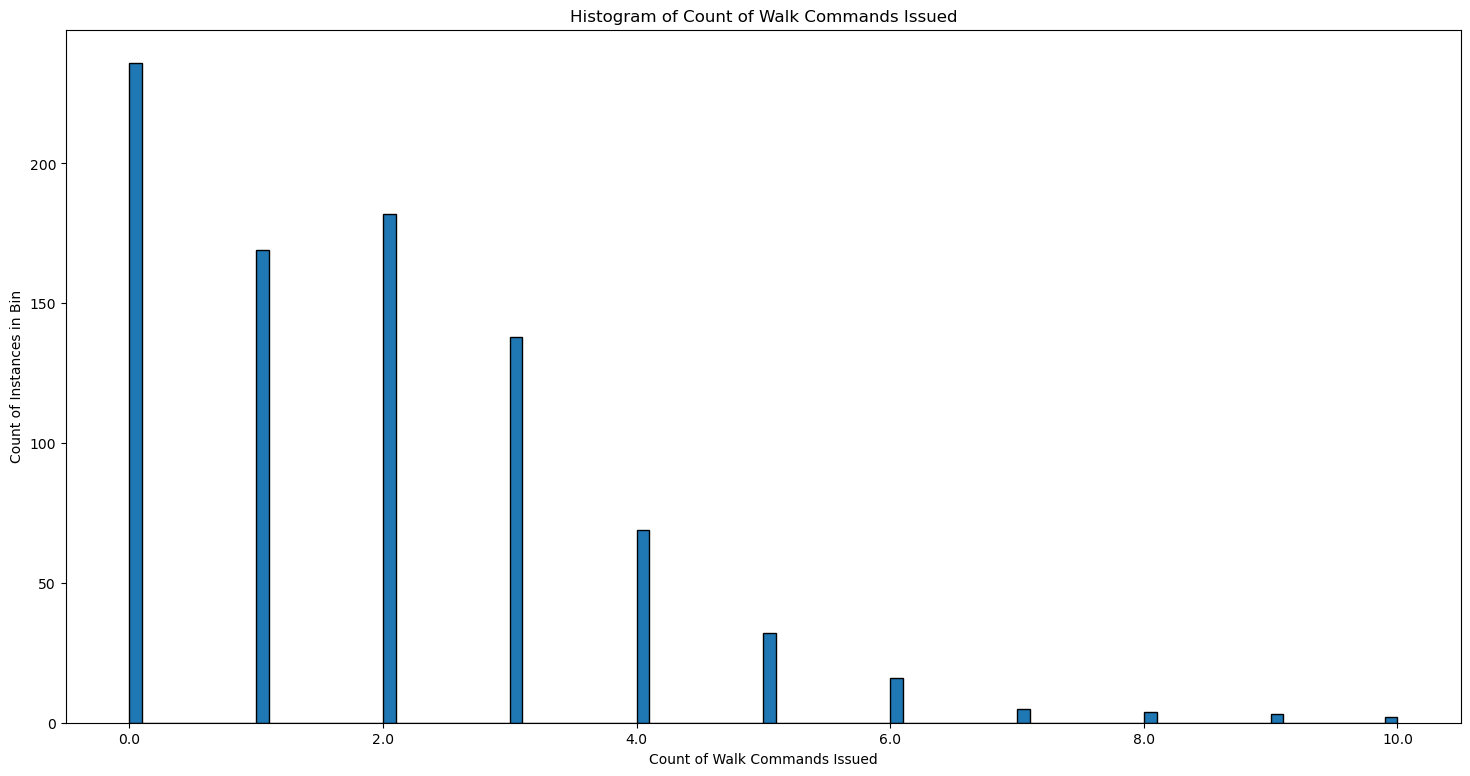

In [11]:

get_xtick_text = lambda text_obj: text_obj.get_position()[0]
xlabel = 'Count of Walk Commands Issued'
title = f'Histogram of {xlabel}'
mask_series = (walk_and_wave_count_df.scene_type == 'Triage') & (walk_and_wave_count_df.is_scene_aborted == False)
fig = nu.plot_histogram(walk_and_wave_count_df[mask_series], 'walk_count', xlabel=xlabel, xtick_text_fn=get_xtick_text, title=title)

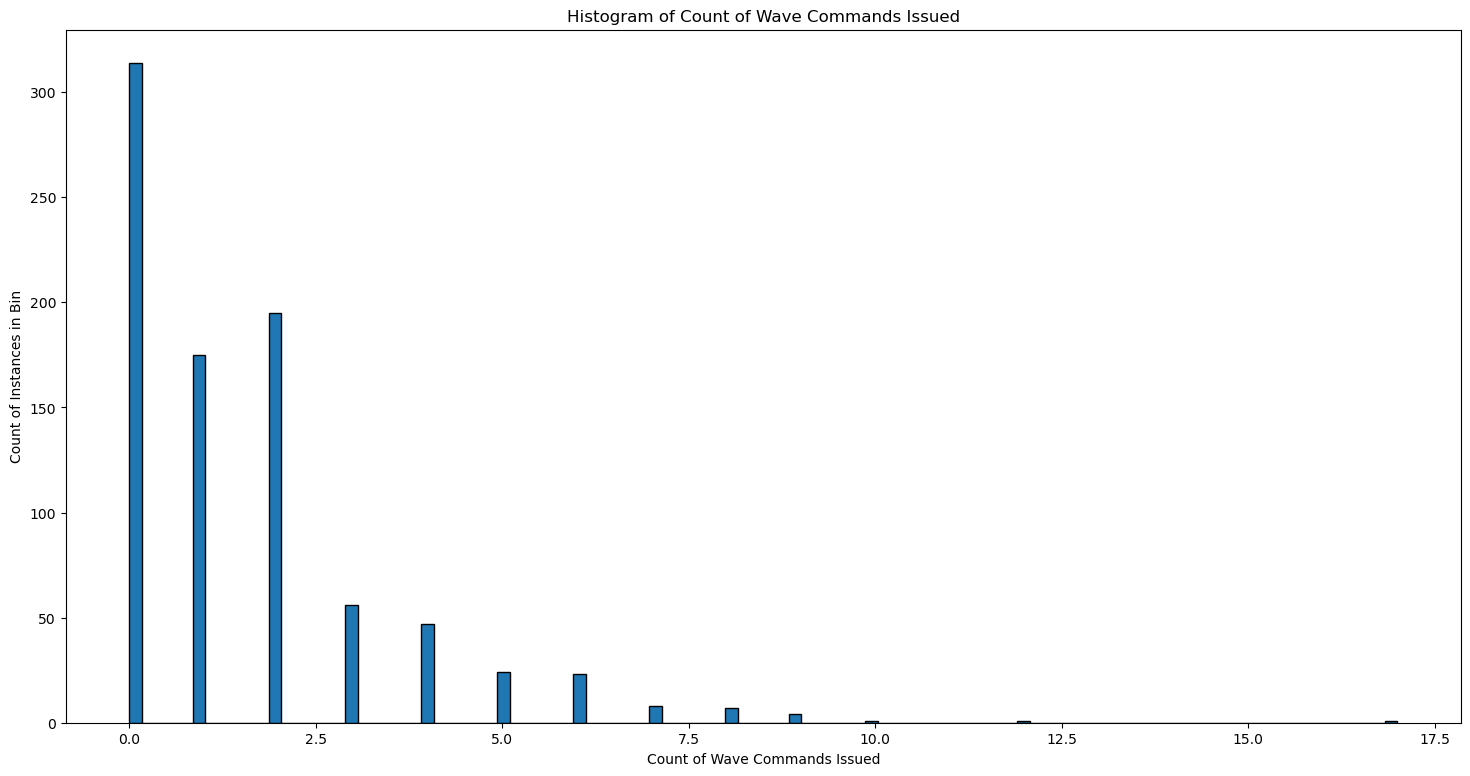

In [10]:

xlabel = 'Count of Wave Commands Issued'
title = f'Histogram of {xlabel}'
mask_series = (walk_and_wave_count_df.scene_type == 'Triage') & (walk_and_wave_count_df.is_scene_aborted == False)
fig = nu.plot_histogram(walk_and_wave_count_df[mask_series], 'wave_count', xlabel=xlabel, xtick_text_fn=get_xtick_text, title=title)

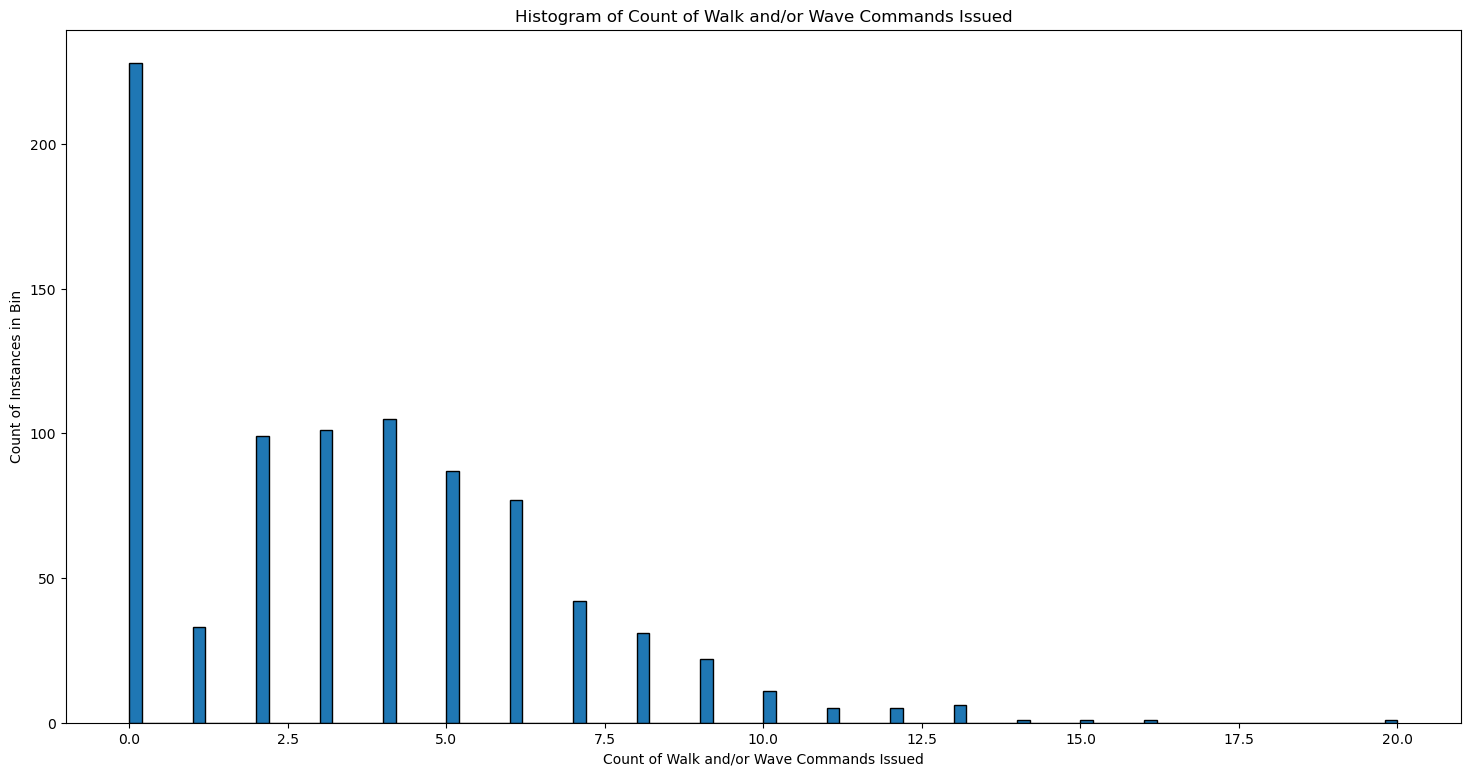

In [12]:

xlabel = 'Count of Walk and/or Wave Commands Issued'
title = f'Histogram of {xlabel}'
mask_series = (walk_and_wave_count_df.scene_type == 'Triage') & (walk_and_wave_count_df.is_scene_aborted == False)
fig = nu.plot_histogram(walk_and_wave_count_df[mask_series], 'walk_and_wave_count', xlabel=xlabel, xtick_text_fn=get_xtick_text, title=title)

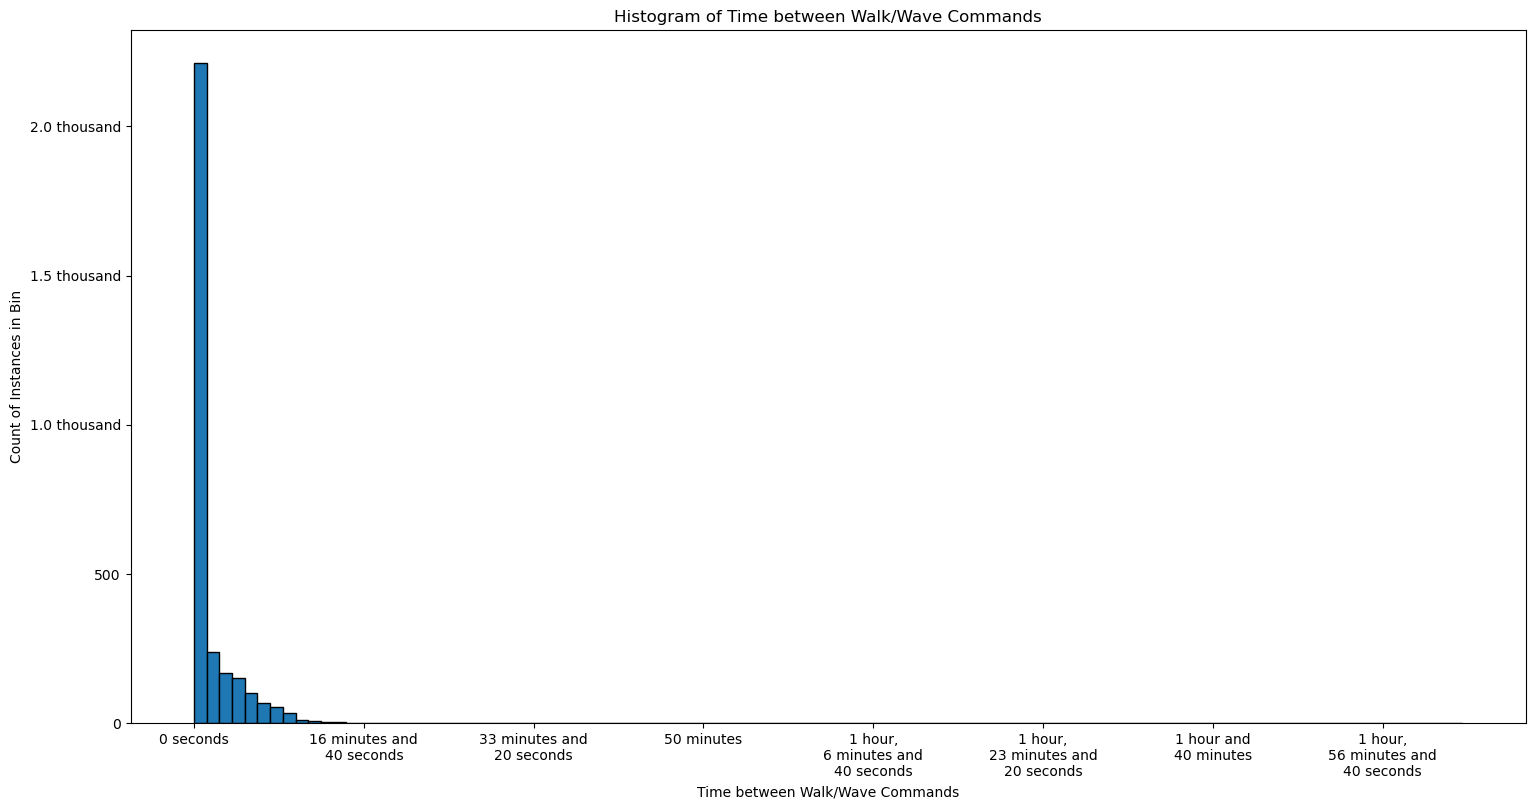

In [36]:

# What is the average time between walk / wave commands?
df = pd.Series(betweens_list).to_frame().rename(columns={0: 'action_tick'})
df['time_diff'] = df.action_tick.diff().map(lambda x: abs(x))
ave_time = humanize.precisedelta(timedelta(milliseconds=df.time_diff.mean()))
# print(f'The average time between walk/wave commands is {ave_time}.')
xlabel = 'Time between Walk/Wave Commands'
get_xtick_text = lambda text_obj: humanize.precisedelta(
    timedelta(milliseconds=text_obj.get_position()[0])
).replace(', ', ',\n').replace(' and ', ' and\n')
title = f'Histogram of {xlabel}'
nu.plot_histogram(df, 'time_diff', xlabel=xlabel, xtick_text_fn=get_xtick_text, title=title)